Data processing part is inspired by Serigne's notebook:
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

# Setting up

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/bryskulov/Desktop/Projects/house_prices'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [29]:
RANDOM_SEED = 42
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

In [30]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [4]:
#mlflow.create_experiment("house-price-prediction")
mlflow.set_experiment("house-price-prediction")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='house-price-prediction', tags={}>

In [5]:
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='house-price-prediction', tags={}>]

# Data Loading

In [65]:
# Reading datasets
train = pd.read_csv('data/train.csv')

In [66]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [67]:
#check the numbers of samples and features
print(f"The train data size before dropping Id feature is : {train.shape} ")

#Save the 'Id' column
train_ID = train['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)

The train data size before dropping Id feature is : (1460, 81) 


# Data processing

## Outliers

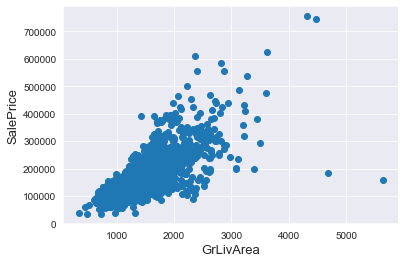

In [68]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [69]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

## Target variable

In [70]:
def plot_distribution(series):
    sns.distplot(series, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(series)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(series, plot=plt)
    plt.show()


 mu = 180932.92 and sigma = 79467.79



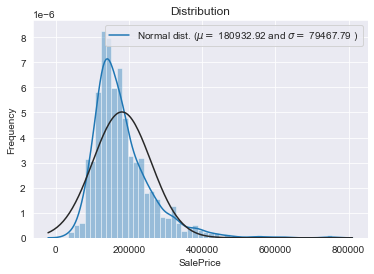

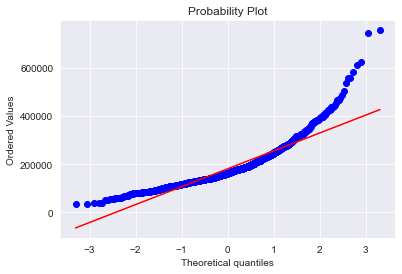

In [71]:
plot_distribution(train['SalePrice'])

In [72]:
# I don't need to normalize the target variable, since I will use boosting methods

In [73]:
train_label = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)
print("train size is : {}".format(train.shape))

train size is : (1458, 79)


## Missing data

In [74]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageType,5.555556
GarageYrBlt,5.555556
GarageFinish,5.555556
GarageQual,5.555556


### Imputing missing values manually

In [75]:
# Don't use this, I leave it to the boosting algorithm

In [76]:
# #Replacing with None
# train["PoolQC"] = train["PoolQC"].fillna("None")
# train["MiscFeature"] = train["MiscFeature"].fillna("None")
# train["Alley"] = train["Alley"].fillna("None")
# train["Fence"] = train["Fence"].fillna("None")
# train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

# #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
# train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
#     lambda x: x.fillna(x.median()))

# for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
#     train[col] = train[col].fillna('None')
    
# for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
#     train[col] = train[col].fillna(0)
    
# for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
#     train[col] = train[col].fillna(0)
    
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     train[col] = train[col].fillna('None')
    
# train["MasVnrType"] = train["MasVnrType"].fillna("None")
# train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

# train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])

# train = train.drop(['Utilities'], axis=1)
# train["Functional"] = train["Functional"].fillna("Typ")
# train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
# train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
# train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
# train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
# train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
# train['MSSubClass'] = train['MSSubClass'].fillna("None")

In [77]:
# #Check remaining missing values if any 
# train_na = (train.isnull().sum() / len(train)) * 100
# train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
# missing_data = pd.DataFrame({'Missing Ratio' :train_na})
# missing_data.head(20)

## Transforming numerical to categorical

In [78]:
#MSSubClass=The building class
train['MSSubClass'] = train['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
train['OverallCond'] = train['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [79]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[col].values)) 
    train[col] = lbl.transform(list(train[col].values))

# shape        
print('Shape train: {}'.format(train.shape))

Shape train: (1458, 79)


## Adding one more important feature

In [108]:
lbl

LabelEncoder()

In [80]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

## Getting dummy categorical features

In [81]:
train = pd.get_dummies(train)
print(train.shape)

(1458, 220)


# Modelling

## XGBoost

## KFold run with Serigne's parameters

In [82]:
#Validation function
n_folds = 5

def rmsle_cv(model):     
    kf = KFold(n_folds, shuffle=True, random_state=RANDOM_SEED).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [83]:
params = {
    'colsample_bytree': 0.4603, 
    'gamma': 0.0468, 
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_child_weight': 1.7817, 
    'n_estimators': 2200,
    'reg_alpha': 0.4640, 
    'reg_lambda': 0.8571,
    'subsample': 0.5213,
    'random_state': 7, 
    'nthread': -1,
}

In [33]:
model_xgb = xgb.XGBRegressor(**params)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 21754.6735 (2052.0685)



## Running a specific model on train/test split

In [84]:
# I split the data in 80:10:10 for train:valid:test dataset

X_train, X_rem, y_train, y_rem = train_test_split(train, train_label, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=RANDOM_SEED)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1166, 220)
(1166,)
(146, 220)
(146,)
(146, 220)
(146,)


(None, None)

In [91]:
XGBOOST_AUTOLOG_DISABLE = True
def run_xgboost(model, data_tag):
    mlflow.xgboost.autolog(disable=XGBOOST_AUTOLOG_DISABLE)
    with mlflow.start_run():
        if XGBOOST_AUTOLOG_DISABLE:
            mlflow.set_tag('developer', 'bryskulov')
            mlflow.set_tag("model", "xgboost")
            mlflow.set_tag('data', data_tag)
            mlflow.log_params(model.get_xgb_params())
        else:            
            pass
        model.fit(X_train, y_train)
        y_pred = model_xgb.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    return rmse

In [36]:
data_tag = 'without normalization, handling missing values, adjusting skewness'
run_xgboost(model_xgb, data_tag)

22427.71162281234


In [37]:
mlflow.xgboost.log_model(model_xgb, artifact_path="models")

ModelInfo(artifact_path='models', flavors={'python_function': {'loader_module': 'mlflow.xgboost', 'python_version': '3.9.10', 'data': 'model.xgb', 'env': 'conda.yaml'}, 'xgboost': {'xgb_version': '1.6.1', 'data': 'model.xgb', 'model_class': 'xgboost.sklearn.XGBRegressor', 'code': None}}, model_uri='runs:/7d98223607434b06ae9e18d5b2e14eb6/models', model_uuid='fbc1b81095454f53ac1cd6e9905ffbf8', run_id='7d98223607434b06ae9e18d5b2e14eb6', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-08-07 14:47:07.101405', mlflow_version='1.27.0')

# HYPEROPT

In [38]:
train_xgb = xgb.DMatrix(X_train, label=y_train)
valid_xgb = xgb.DMatrix(X_valid, label=y_valid)
test_xgb = xgb.DMatrix(X_test, label=y_test)

def objective(params):
    mlflow.xgboost.autolog(disable=XGBOOST_AUTOLOG_DISABLE)
    with mlflow.start_run():
        mlflow.set_tag('developer', 'bryskulov')
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        model_xgb = xgb.train(
            params=params,
            dtrain=train_xgb,
            evals=[(valid_xgb, 'validation')],
            num_boost_round=2200,
            early_stopping_rounds=50)
        
        y_pred = model_xgb.predict(test_xgb)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [39]:
search_space = {
    'gamma': hp.loguniform('gamma', -5, -1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
    'subsample': hp.uniform('subsample', 0.4,1),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': RANDOM_SEED
}

In [43]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[16:47:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:149424.39429                                                         
[1]	validation-rmse:110879.09107                                                         
[2]	validation-rmse:84717.23298                                                          
[3]	validation-rmse:63549.60804                                                          
[4]	validation-rmse:50668.64574                                                          
[5]	validation-rmse:40898.00397                                                          
[6]	validation-rmse:34775.42313                                                          
[7]	validation-rmse:31075.92724                                                          
[8]	validation-rmse:29364.36905                                         

[88]	validation-rmse:25267.37848                                                         
[89]	validation-rmse:25280.41400                                                         
[90]	validation-rmse:25285.11568                                                         
[91]	validation-rmse:25280.01219                                                         
[92]	validation-rmse:25261.21189                                                         
[93]	validation-rmse:25305.56769                                                         
[94]	validation-rmse:25365.22105                                                         
[95]	validation-rmse:25371.97905                                                         
[96]	validation-rmse:25370.85476                                                         
[97]	validation-rmse:25360.01823                                                         
[98]	validation-rmse:25352.38983                                                         
[99]	valid

[40]	validation-rmse:22466.66017                                                         
[41]	validation-rmse:22160.18956                                                         
[42]	validation-rmse:21976.08538                                                         
[43]	validation-rmse:21953.83587                                                         
[44]	validation-rmse:21792.78961                                                         
[45]	validation-rmse:21644.37384                                                         
[46]	validation-rmse:21620.33956                                                         
[47]	validation-rmse:21545.03667                                                         
[48]	validation-rmse:21436.03352                                                         
[49]	validation-rmse:21376.25832                                                         
[50]	validation-rmse:21310.30309                                                         
[51]	valid

[131]	validation-rmse:20841.48724                                                        
[132]	validation-rmse:20839.71333                                                        
[133]	validation-rmse:20823.58823                                                        
[134]	validation-rmse:20811.74929                                                        
[135]	validation-rmse:20860.64223                                                        
[136]	validation-rmse:20845.68712                                                        
[137]	validation-rmse:20881.72496                                                        
[138]	validation-rmse:20860.63258                                                        
[139]	validation-rmse:20806.41442                                                        
[140]	validation-rmse:20830.64110                                                        
[141]	validation-rmse:20834.21492                                                        
[142]	vali

[222]	validation-rmse:20765.60183                                                        
[223]	validation-rmse:20778.89789                                                        
[224]	validation-rmse:20768.16842                                                        
[225]	validation-rmse:20775.09764                                                        
[226]	validation-rmse:20792.40939                                                        
[227]	validation-rmse:20788.79691                                                        
[228]	validation-rmse:20798.46340                                                        
[229]	validation-rmse:20796.48675                                                        
[230]	validation-rmse:20800.71117                                                        
[231]	validation-rmse:20799.58617                                                        
[232]	validation-rmse:20800.02271                                                        
[233]	vali

[53]	validation-rmse:19580.35652                                                         
[54]	validation-rmse:19547.64854                                                         
[55]	validation-rmse:19595.23184                                                         
[56]	validation-rmse:19675.82527                                                         
[57]	validation-rmse:19714.60253                                                         
[58]	validation-rmse:19828.76035                                                         
[59]	validation-rmse:19804.90965                                                         
[60]	validation-rmse:19846.87390                                                         
[61]	validation-rmse:19762.15449                                                         
[62]	validation-rmse:19639.84111                                                         
[63]	validation-rmse:19800.15664                                                         
[64]	valid

[58]	validation-rmse:22743.12001                                                         
[59]	validation-rmse:22496.96417                                                         
[60]	validation-rmse:22285.74136                                                         
[61]	validation-rmse:22148.25675                                                         
[62]	validation-rmse:22043.70861                                                         
[63]	validation-rmse:21984.30101                                                         
[64]	validation-rmse:21832.60579                                                         
[65]	validation-rmse:21705.20545                                                         
[66]	validation-rmse:21565.37566                                                         
[67]	validation-rmse:21504.17627                                                         
[68]	validation-rmse:21480.23890                                                         
[69]	valid

[149]	validation-rmse:20604.81466                                                        
[150]	validation-rmse:20585.32308                                                        
[151]	validation-rmse:20597.59686                                                        
[152]	validation-rmse:20577.55427                                                        
[153]	validation-rmse:20583.10430                                                        
[154]	validation-rmse:20616.19862                                                        
[155]	validation-rmse:20623.61041                                                        
[156]	validation-rmse:20604.91828                                                        
[157]	validation-rmse:20587.18629                                                        
[158]	validation-rmse:20602.69648                                                        
[159]	validation-rmse:20567.61560                                                        
[160]	vali

[52]	validation-rmse:20988.67104                                                         
[53]	validation-rmse:20892.63418                                                         
[54]	validation-rmse:20905.21077                                                         
[55]	validation-rmse:20903.72197                                                         
[56]	validation-rmse:20917.31298                                                         
[57]	validation-rmse:20950.44392                                                         
[58]	validation-rmse:20954.58769                                                         
[59]	validation-rmse:20968.37557                                                         
[60]	validation-rmse:20881.33848                                                         
[61]	validation-rmse:20837.16348                                                         
[62]	validation-rmse:20802.67381                                                         
[63]	valid

[27]	validation-rmse:24399.50885                                                         
[28]	validation-rmse:24570.21732                                                         
[29]	validation-rmse:24158.46963                                                         
[30]	validation-rmse:24130.29285                                                         
[31]	validation-rmse:24242.90238                                                         
[32]	validation-rmse:24319.74961                                                         
[33]	validation-rmse:24881.19598                                                         
[34]	validation-rmse:25053.90738                                                         
[35]	validation-rmse:24792.30941                                                         
[36]	validation-rmse:24656.88705                                                         
[37]	validation-rmse:25397.52993                                                         
[38]	valid

[118]	validation-rmse:24617.43916                                                        
[119]	validation-rmse:24538.78224                                                        
[120]	validation-rmse:24555.38670                                                        
[121]	validation-rmse:24734.94496                                                        
[122]	validation-rmse:24405.20562                                                        
[123]	validation-rmse:24475.25900                                                        
[124]	validation-rmse:24417.50088                                                        
[125]	validation-rmse:24546.76858                                                        
[126]	validation-rmse:24321.66842                                                        
[127]	validation-rmse:24255.63413                                                        
[128]	validation-rmse:24281.65191                                                        
[129]	vali

[62]	validation-rmse:19959.05055                                                         
[63]	validation-rmse:19845.29074                                                         
[64]	validation-rmse:19698.38576                                                         
[65]	validation-rmse:19613.39072                                                         
[66]	validation-rmse:19472.38334                                                         
[67]	validation-rmse:19401.17424                                                         
[68]	validation-rmse:19495.37978                                                         
[69]	validation-rmse:19400.12935                                                         
[70]	validation-rmse:19309.99106                                                         
[71]	validation-rmse:19253.50853                                                         
[72]	validation-rmse:19210.19641                                                         
[73]	valid

[153]	validation-rmse:18645.28426                                                        
[154]	validation-rmse:18528.50263                                                        
[155]	validation-rmse:18600.25868                                                        
[156]	validation-rmse:18690.86672                                                        
[157]	validation-rmse:18650.95304                                                        
[158]	validation-rmse:18672.77777                                                        
[159]	validation-rmse:18609.41627                                                        
[160]	validation-rmse:18682.18168                                                        
[161]	validation-rmse:18659.90476                                                        
[162]	validation-rmse:18668.85645                                                        
[163]	validation-rmse:18651.46512                                                        
[164]	vali

[244]	validation-rmse:18817.93516                                                        
[245]	validation-rmse:18842.62109                                                        
[246]	validation-rmse:18831.95080                                                        
[247]	validation-rmse:18793.40375                                                        
[248]	validation-rmse:18835.42533                                                        
[249]	validation-rmse:18788.84139                                                        
[250]	validation-rmse:18752.05564                                                        
[251]	validation-rmse:18760.30653                                                        
[252]	validation-rmse:18766.35539                                                        
[253]	validation-rmse:18781.27878                                                        
[254]	validation-rmse:18742.49503                                                        
[255]	vali

[75]	validation-rmse:20867.29432                                                         
[76]	validation-rmse:20826.49161                                                         
[77]	validation-rmse:20868.77303                                                         
[78]	validation-rmse:20873.81676                                                         
[79]	validation-rmse:20923.55822                                                         
[80]	validation-rmse:20886.28031                                                         
[81]	validation-rmse:20905.51729                                                         
[82]	validation-rmse:20906.87071                                                         
[16:47:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:61881.79419                                         

[22]	validation-rmse:37250.89513                                                         
[23]	validation-rmse:35121.59317                                                         
[24]	validation-rmse:33265.95014                                                         
[25]	validation-rmse:31691.20437                                                         
[26]	validation-rmse:30260.25312                                                         
[27]	validation-rmse:28900.76248                                                         
[28]	validation-rmse:27667.41310                                                         
[29]	validation-rmse:26599.66695                                                         
[30]	validation-rmse:25579.41612                                                         
[31]	validation-rmse:24675.34763                                                         
[32]	validation-rmse:23938.06157                                                         
[33]	valid

[113]	validation-rmse:19423.71759                                                        
[114]	validation-rmse:19416.56060                                                        
[115]	validation-rmse:19431.33223                                                        
[116]	validation-rmse:19437.73160                                                        
[117]	validation-rmse:19459.97591                                                        
[118]	validation-rmse:19487.53732                                                        
[119]	validation-rmse:19505.81860                                                        
[120]	validation-rmse:19513.93095                                                        
[121]	validation-rmse:19497.64345                                                        
[122]	validation-rmse:19491.74498                                                        
[123]	validation-rmse:19484.28427                                                        
[124]	vali

[36]	validation-rmse:34874.74814                                                         
[37]	validation-rmse:33681.13505                                                         
[38]	validation-rmse:32666.57812                                                         
[39]	validation-rmse:31688.51593                                                         
[40]	validation-rmse:30815.81784                                                         
[41]	validation-rmse:29884.82935                                                         
[42]	validation-rmse:29071.26703                                                         
[43]	validation-rmse:28263.78995                                                         
[44]	validation-rmse:27611.63311                                                         
[45]	validation-rmse:27097.42771                                                         
[46]	validation-rmse:26387.97449                                                         
[47]	valid

[127]	validation-rmse:19393.49974                                                        
[128]	validation-rmse:19370.05560                                                        
[129]	validation-rmse:19411.99689                                                        
[130]	validation-rmse:19445.58898                                                        
[131]	validation-rmse:19417.87499                                                        
[132]	validation-rmse:19465.76107                                                        
[133]	validation-rmse:19467.43286                                                        
[134]	validation-rmse:19469.79963                                                        
[135]	validation-rmse:19483.99853                                                        
[136]	validation-rmse:19492.22794                                                        
[137]	validation-rmse:19442.98280                                                        
[138]	vali

[218]	validation-rmse:18879.87040                                                        
[219]	validation-rmse:18892.50849                                                        
[220]	validation-rmse:18883.93755                                                        
[221]	validation-rmse:18875.80882                                                        
[222]	validation-rmse:18867.38549                                                        
[223]	validation-rmse:18821.54120                                                        
[224]	validation-rmse:18808.91053                                                        
[225]	validation-rmse:18813.32157                                                        
[226]	validation-rmse:18814.90510                                                        
[227]	validation-rmse:18813.24839                                                        
[228]	validation-rmse:18790.96191                                                        
[229]	vali

[309]	validation-rmse:18559.91749                                                        
[310]	validation-rmse:18570.02252                                                        
[311]	validation-rmse:18560.12510                                                        
[312]	validation-rmse:18577.95763                                                        
[313]	validation-rmse:18597.43505                                                        
[314]	validation-rmse:18596.92678                                                        
[315]	validation-rmse:18602.24308                                                        
[316]	validation-rmse:18572.70636                                                        
[317]	validation-rmse:18564.97370                                                        
[318]	validation-rmse:18551.17156                                                        
[319]	validation-rmse:18563.22557                                                        
[320]	vali

[400]	validation-rmse:18504.60363                                                        
[401]	validation-rmse:18534.08813                                                        
[402]	validation-rmse:18533.64115                                                        
[403]	validation-rmse:18533.68351                                                        
[404]	validation-rmse:18529.54229                                                        
[405]	validation-rmse:18532.70480                                                        
[16:48:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:135405.91823                                                         
[1]	validation-rmse:92774.02241                                                          
[2]	validation-rmse:64892.24258                                         

[19]	validation-rmse:31062.96386                                                         
[20]	validation-rmse:31488.98000                                                         
[21]	validation-rmse:31865.65678                                                         
[22]	validation-rmse:31337.12302                                                         
[23]	validation-rmse:31610.73019                                                         
[24]	validation-rmse:31942.14608                                                         
[25]	validation-rmse:31850.74638                                                         
[26]	validation-rmse:32161.38767                                                         
[27]	validation-rmse:32106.85915                                                         
[28]	validation-rmse:31939.14898                                                         
[29]	validation-rmse:32218.79799                                                         
[30]	valid

[41]	validation-rmse:27347.78749                                                         
[42]	validation-rmse:27355.81334                                                         
[43]	validation-rmse:27376.12815                                                         
[44]	validation-rmse:27379.09600                                                         
[45]	validation-rmse:27387.11495                                                         
[46]	validation-rmse:27372.60055                                                         
[47]	validation-rmse:27383.95117                                                         
[48]	validation-rmse:27382.62681                                                         
[49]	validation-rmse:27381.38556                                                         
[50]	validation-rmse:27386.40470                                                         
[51]	validation-rmse:27406.76706                                                         
[52]	valid

[66]	validation-rmse:23562.85488                                                         
[67]	validation-rmse:23584.23154                                                         
[68]	validation-rmse:23569.50817                                                         
[69]	validation-rmse:23531.08259                                                         
[70]	validation-rmse:23510.56897                                                         
[71]	validation-rmse:23558.25366                                                         
[16:48:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:172241.79158                                                         
[1]	validation-rmse:148479.62601                                                         
[2]	validation-rmse:127875.20796                                        

[82]	validation-rmse:21580.41097                                                         
[83]	validation-rmse:21575.66782                                                         
[84]	validation-rmse:21575.12033                                                         
[85]	validation-rmse:21574.11682                                                         
[86]	validation-rmse:21581.96592                                                         
[87]	validation-rmse:21574.03282                                                         
[88]	validation-rmse:21577.80529                                                         
[89]	validation-rmse:21584.37226                                                         
[90]	validation-rmse:21591.70347                                                         
[91]	validation-rmse:21597.40781                                                         
[92]	validation-rmse:21597.89095                                                         
[93]	valid

[32]	validation-rmse:26359.16934                                                         
[33]	validation-rmse:26483.77363                                                         
[34]	validation-rmse:26520.06352                                                         
[35]	validation-rmse:26619.14363                                                         
[36]	validation-rmse:26599.63057                                                         
[37]	validation-rmse:26660.59397                                                         
[38]	validation-rmse:26675.65707                                                         
[39]	validation-rmse:26712.21751                                                         
[40]	validation-rmse:26619.30456                                                         
[41]	validation-rmse:26600.25118                                                         
[42]	validation-rmse:26581.99943                                                         
[43]	valid

[60]	validation-rmse:22751.98072                                                         
[61]	validation-rmse:22750.45521                                                         
[62]	validation-rmse:22752.03115                                                         
[63]	validation-rmse:22753.22209                                                         
[64]	validation-rmse:22752.93403                                                         
[65]	validation-rmse:22751.22804                                                         
[66]	validation-rmse:22749.46549                                                         
[67]	validation-rmse:22747.15478                                                         
[68]	validation-rmse:22746.11013                                                         
[69]	validation-rmse:22745.77204                                                         
[70]	validation-rmse:22747.73011                                                         
[71]	valid

[20]	validation-rmse:23031.84962                                                         
[21]	validation-rmse:23437.21601                                                         
[22]	validation-rmse:23292.35676                                                         
[23]	validation-rmse:22987.06991                                                         
[24]	validation-rmse:22958.93840                                                         
[25]	validation-rmse:23044.36347                                                         
[26]	validation-rmse:23128.81678                                                         
[27]	validation-rmse:22716.21400                                                         
[28]	validation-rmse:22792.98674                                                         
[29]	validation-rmse:22643.16831                                                         
[30]	validation-rmse:22919.20437                                                         
[31]	valid

[111]	validation-rmse:22070.57380                                                        
[112]	validation-rmse:22103.51478                                                        
[113]	validation-rmse:22104.75144                                                        
[114]	validation-rmse:22110.30109                                                        
[115]	validation-rmse:22071.03970                                                        
[116]	validation-rmse:22123.46131                                                        
[117]	validation-rmse:22125.15890                                                        
[118]	validation-rmse:22145.61789                                                        
[119]	validation-rmse:22138.38865                                                        
[16:48:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of 

[79]	validation-rmse:19836.46709                                                         
[80]	validation-rmse:19852.96878                                                         
[81]	validation-rmse:19837.34988                                                         
[82]	validation-rmse:19837.46311                                                         
[83]	validation-rmse:19881.77332                                                         
[84]	validation-rmse:19899.61854                                                         
[85]	validation-rmse:19865.84604                                                         
[86]	validation-rmse:19823.74177                                                         
[87]	validation-rmse:19841.14514                                                         
[88]	validation-rmse:19841.39423                                                         
[89]	validation-rmse:19840.01510                                                         
[90]	valid

[42]	validation-rmse:28037.27980                                                         
[43]	validation-rmse:27984.55548                                                         
[44]	validation-rmse:28024.06105                                                         
[45]	validation-rmse:28171.90364                                                         
[46]	validation-rmse:27703.39353                                                         
[47]	validation-rmse:27545.02267                                                         
[48]	validation-rmse:27606.93232                                                         
[49]	validation-rmse:27653.97760                                                         
[50]	validation-rmse:27630.87205                                                         
[51]	validation-rmse:27212.68374                                                         
[52]	validation-rmse:27207.40789                                                         
[53]	valid

[63]	validation-rmse:23883.76493                                                         
[64]	validation-rmse:23877.67708                                                         
[65]	validation-rmse:24019.54470                                                         
[66]	validation-rmse:24037.33878                                                         
[67]	validation-rmse:24279.49971                                                         
[68]	validation-rmse:24249.77351                                                         
[69]	validation-rmse:24195.76317                                                         
[70]	validation-rmse:24394.27165                                                         
[71]	validation-rmse:24392.12311                                                         
[72]	validation-rmse:24280.26865                                                         
[73]	validation-rmse:24269.40074                                                         
[74]	valid

[36]	validation-rmse:35364.52263                                                         
[37]	validation-rmse:34216.70579                                                         
[38]	validation-rmse:33010.86346                                                         
[39]	validation-rmse:31936.76436                                                         
[40]	validation-rmse:31046.18732                                                         
[41]	validation-rmse:30243.84335                                                         
[42]	validation-rmse:29459.93134                                                         
[43]	validation-rmse:28649.92308                                                         
[44]	validation-rmse:28075.19984                                                         
[45]	validation-rmse:27488.85083                                                         
[46]	validation-rmse:26706.92708                                                         
[47]	valid

[127]	validation-rmse:18864.87714                                                        
[128]	validation-rmse:18847.10044                                                        
[129]	validation-rmse:18878.14733                                                        
[130]	validation-rmse:18877.82053                                                        
[131]	validation-rmse:18869.64749                                                        
[132]	validation-rmse:18888.92205                                                        
[133]	validation-rmse:18887.31659                                                        
[134]	validation-rmse:18889.40121                                                        
[135]	validation-rmse:18944.24137                                                        
[136]	validation-rmse:18911.88348                                                        
[137]	validation-rmse:18904.71341                                                        
[138]	vali

[36]	validation-rmse:20524.81565                                                         
[37]	validation-rmse:20418.31400                                                         
[38]	validation-rmse:20270.61899                                                         
[39]	validation-rmse:20323.87781                                                         
[40]	validation-rmse:20356.05596                                                         
[41]	validation-rmse:20218.89140                                                         
[42]	validation-rmse:20097.04240                                                         
[43]	validation-rmse:20013.79267                                                         
[44]	validation-rmse:19982.15892                                                         
[45]	validation-rmse:20261.62240                                                         
[46]	validation-rmse:20238.41864                                                         
[47]	valid

[127]	validation-rmse:19394.49360                                                        
[128]	validation-rmse:19364.16145                                                        
[129]	validation-rmse:19398.94793                                                        
[130]	validation-rmse:19461.11873                                                        
[131]	validation-rmse:19525.71666                                                        
[132]	validation-rmse:19541.02863                                                        
[133]	validation-rmse:19530.98197                                                        
[134]	validation-rmse:19585.06816                                                        
[135]	validation-rmse:19685.87142                                                        
[136]	validation-rmse:19675.92588                                                        
[137]	validation-rmse:19658.75311                                                        
[138]	vali

[76]	validation-rmse:20547.44973                                                         
[77]	validation-rmse:20542.48830                                                         
[78]	validation-rmse:20597.91936                                                         
[79]	validation-rmse:20575.24687                                                         
[80]	validation-rmse:20558.15318                                                         
[81]	validation-rmse:20598.51641                                                         
[82]	validation-rmse:20555.32384                                                         
[83]	validation-rmse:20551.09968                                                         
[84]	validation-rmse:20589.86012                                                         
[85]	validation-rmse:20538.75877                                                         
[86]	validation-rmse:20483.46619                                                         
[87]	valid

[24]	validation-rmse:22282.24274                                                         
[25]	validation-rmse:22357.09630                                                         
[26]	validation-rmse:22245.66840                                                         
[27]	validation-rmse:22299.00519                                                         
[28]	validation-rmse:22221.43557                                                         
[29]	validation-rmse:21985.28998                                                         
[30]	validation-rmse:21740.46354                                                         
[31]	validation-rmse:21629.94770                                                         
[32]	validation-rmse:21825.65475                                                         
[33]	validation-rmse:21851.36366                                                         
[34]	validation-rmse:21777.16406                                                         
[35]	valid

[115]	validation-rmse:21048.18139                                                        
[116]	validation-rmse:21026.38417                                                        
[117]	validation-rmse:20984.93843                                                        
[118]	validation-rmse:20997.53674                                                        
[119]	validation-rmse:21047.24642                                                        
[120]	validation-rmse:21002.54750                                                        
[121]	validation-rmse:20953.14121                                                        
[122]	validation-rmse:20933.81393                                                        
[123]	validation-rmse:20925.03620                                                        
[124]	validation-rmse:20936.73741                                                        
[125]	validation-rmse:20902.37919                                                        
[126]	vali

[18]	validation-rmse:24067.72704                                                         
[19]	validation-rmse:23896.58347                                                         
[20]	validation-rmse:24289.35290                                                         
[21]	validation-rmse:23821.54284                                                         
[22]	validation-rmse:23654.63008                                                         
[23]	validation-rmse:23935.50886                                                         
[24]	validation-rmse:23925.25907                                                         
[25]	validation-rmse:24103.96246                                                         
[26]	validation-rmse:24044.82167                                                         
[27]	validation-rmse:24254.18621                                                         
[28]	validation-rmse:24280.00276                                                         
[29]	valid

[34]	validation-rmse:19840.16417                                                         
[35]	validation-rmse:19762.95182                                                         
[36]	validation-rmse:19731.19517                                                         
[37]	validation-rmse:19650.60721                                                         
[38]	validation-rmse:19599.26743                                                         
[39]	validation-rmse:19554.88745                                                         
[40]	validation-rmse:19512.78462                                                         
[41]	validation-rmse:19344.59052                                                         
[42]	validation-rmse:19335.67316                                                         
[43]	validation-rmse:19345.47160                                                         
[44]	validation-rmse:19268.78705                                                         
[45]	valid

[17]	validation-rmse:22839.21964                                                         
[18]	validation-rmse:22855.17172                                                         
[19]	validation-rmse:23015.35693                                                         
[20]	validation-rmse:22921.56929                                                         
[21]	validation-rmse:22879.53691                                                         
[22]	validation-rmse:22807.80938                                                         
[23]	validation-rmse:22848.09035                                                         
[24]	validation-rmse:22883.47261                                                         
[25]	validation-rmse:22835.95955                                                         
[26]	validation-rmse:22738.56573                                                         
[27]	validation-rmse:22697.24335                                                         
[28]	valid

[44]	validation-rmse:21820.64249                                                         
[45]	validation-rmse:21749.55531                                                         
[46]	validation-rmse:21898.27219                                                         
[47]	validation-rmse:21982.87624                                                         
[48]	validation-rmse:22126.59923                                                         
[49]	validation-rmse:22219.26511                                                         
[50]	validation-rmse:22080.87192                                                         
[51]	validation-rmse:22118.81607                                                         
[52]	validation-rmse:21989.34474                                                         
[53]	validation-rmse:21979.82539                                                         
[54]	validation-rmse:21927.97931                                                         
[55]	valid

[0]	validation-rmse:157705.02588                                                         
[1]	validation-rmse:124627.18352                                                         
[2]	validation-rmse:99958.09208                                                          
[3]	validation-rmse:79567.70127                                                          
[4]	validation-rmse:64737.09820                                                          
[5]	validation-rmse:52191.75656                                                          
[6]	validation-rmse:43113.23845                                                          
[7]	validation-rmse:36754.47809                                                          
[8]	validation-rmse:31729.40310                                                          
[9]	validation-rmse:28450.00810                                                          
[10]	validation-rmse:26478.04625                                                         
[11]	valid

[15]	validation-rmse:68454.56505                                                         
[16]	validation-rmse:64385.76826                                                         
[17]	validation-rmse:60423.00202                                                         
[18]	validation-rmse:57103.12054                                                         
[19]	validation-rmse:54006.27782                                                         
[20]	validation-rmse:50900.29542                                                         
[21]	validation-rmse:48201.70795                                                         
[22]	validation-rmse:45539.46481                                                         
[23]	validation-rmse:43310.23735                                                         
[24]	validation-rmse:41238.60135                                                         
[25]	validation-rmse:39425.78820                                                         
[26]	valid

[106]	validation-rmse:20478.31408                                                        
[107]	validation-rmse:20446.30102                                                        
[108]	validation-rmse:20394.69145                                                        
[109]	validation-rmse:20391.13382                                                        
[110]	validation-rmse:20409.32694                                                        
[111]	validation-rmse:20405.19996                                                        
[112]	validation-rmse:20426.30012                                                        
[113]	validation-rmse:20433.49211                                                        
[114]	validation-rmse:20365.26906                                                        
[115]	validation-rmse:20366.10662                                                        
[116]	validation-rmse:20371.79969                                                        
[117]	vali

[197]	validation-rmse:20116.13277                                                        
[198]	validation-rmse:20088.40567                                                        
[199]	validation-rmse:20102.69397                                                        
[200]	validation-rmse:20118.72986                                                        
[201]	validation-rmse:20149.05888                                                        
[202]	validation-rmse:20132.84464                                                        
[203]	validation-rmse:20121.61945                                                        
[204]	validation-rmse:20102.13420                                                        
[205]	validation-rmse:20093.87393                                                        
[206]	validation-rmse:20054.87497                                                        
[207]	validation-rmse:20051.64931                                                        
[208]	vali

[288]	validation-rmse:19871.57962                                                        
[289]	validation-rmse:19871.72615                                                        
[290]	validation-rmse:19859.46563                                                        
[291]	validation-rmse:19836.24581                                                        
[292]	validation-rmse:19849.82661                                                        
[293]	validation-rmse:19860.11423                                                        
[294]	validation-rmse:19890.84073                                                        
[295]	validation-rmse:19881.08383                                                        
[296]	validation-rmse:19885.75076                                                        
[297]	validation-rmse:19883.89637                                                        
[298]	validation-rmse:19861.23042                                                        
[299]	vali

[379]	validation-rmse:19738.66161                                                        
[380]	validation-rmse:19737.96350                                                        
[381]	validation-rmse:19716.53688                                                        
[382]	validation-rmse:19706.08141                                                        
[383]	validation-rmse:19707.21222                                                        
[384]	validation-rmse:19683.78071                                                        
[385]	validation-rmse:19685.76288                                                        
[386]	validation-rmse:19684.15302                                                        
[387]	validation-rmse:19655.53612                                                        
[388]	validation-rmse:19653.11454                                                        
[389]	validation-rmse:19674.19642                                                        
[390]	vali

[470]	validation-rmse:19524.36044                                                        
[471]	validation-rmse:19537.45688                                                        
[472]	validation-rmse:19536.47735                                                        
[473]	validation-rmse:19542.91132                                                        
[474]	validation-rmse:19539.18677                                                        
[475]	validation-rmse:19545.60917                                                        
[476]	validation-rmse:19549.13667                                                        
[477]	validation-rmse:19515.56700                                                        
[478]	validation-rmse:19512.37177                                                        
[479]	validation-rmse:19509.09169                                                        
[480]	validation-rmse:19510.50376                                                        
[481]	vali

[50]	validation-rmse:23240.03178                                                         
[51]	validation-rmse:23160.34790                                                         
[52]	validation-rmse:23164.58448                                                         
[53]	validation-rmse:23186.55161                                                         
[54]	validation-rmse:23072.74552                                                         
[55]	validation-rmse:23030.53450                                                         
[56]	validation-rmse:23182.99566                                                         
[57]	validation-rmse:23224.90990                                                         
[58]	validation-rmse:23316.29679                                                         
[59]	validation-rmse:23256.62883                                                         
[60]	validation-rmse:23213.16528                                                         
[61]	valid

[58]	validation-rmse:21771.86096                                                         
[59]	validation-rmse:21753.91604                                                         
[60]	validation-rmse:21752.43618                                                         
[61]	validation-rmse:21746.33031                                                         
[62]	validation-rmse:21739.49288                                                         
[63]	validation-rmse:21728.00953                                                         
[64]	validation-rmse:21733.30653                                                         
[65]	validation-rmse:21725.08100                                                         
[66]	validation-rmse:21739.99837                                                         
[67]	validation-rmse:21718.53206                                                         
[68]	validation-rmse:21714.15049                                                         
[69]	valid

[64]	validation-rmse:20609.43875                                                         
[65]	validation-rmse:20592.65188                                                         
[66]	validation-rmse:20577.83817                                                         
[67]	validation-rmse:20521.62919                                                         
[68]	validation-rmse:20587.18011                                                         
[69]	validation-rmse:20513.31486                                                         
[70]	validation-rmse:20536.33634                                                         
[71]	validation-rmse:20596.05024                                                         
[72]	validation-rmse:20625.49808                                                         
[73]	validation-rmse:20565.22467                                                         
[74]	validation-rmse:20486.22461                                                         
[75]	valid

[4]	validation-rmse:127010.99892                                                         
[5]	validation-rmse:115586.43545                                                         
[6]	validation-rmse:106008.81209                                                         
[7]	validation-rmse:97068.12421                                                          
[8]	validation-rmse:88739.32729                                                          
[9]	validation-rmse:81715.10151                                                          
[10]	validation-rmse:75077.00278                                                         
[11]	validation-rmse:68167.52006                                                         
[12]	validation-rmse:62594.16526                                                         
[13]	validation-rmse:57398.04702                                                         
[14]	validation-rmse:52889.08101                                                         
[15]	valid

[95]	validation-rmse:19600.85697                                                         
[96]	validation-rmse:19529.44917                                                         
[97]	validation-rmse:19524.91239                                                         
[98]	validation-rmse:19495.38327                                                         
[99]	validation-rmse:19516.39222                                                         
[100]	validation-rmse:19570.27867                                                        
[101]	validation-rmse:19603.97330                                                        
[102]	validation-rmse:19562.90554                                                        
[103]	validation-rmse:19546.11118                                                        
[104]	validation-rmse:19532.21337                                                        
[105]	validation-rmse:19541.48434                                                        
[106]	vali

[16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:169987.54196                                                         
[1]	validation-rmse:143893.41040                                                         
[2]	validation-rmse:121641.53478                                                         
[3]	validation-rmse:102925.41092                                                         
[4]	validation-rmse:87386.87941                                                          
[5]	validation-rmse:74474.85394                                                          
[6]	validation-rmse:63564.50264                                                          
[7]	validation-rmse:55164.11463                                                          
[8]	validation-rmse:47647.26784                                         

[88]	validation-rmse:20774.88920                                                         
[89]	validation-rmse:20738.99353                                                         
[90]	validation-rmse:20715.54706                                                         
[91]	validation-rmse:20680.69543                                                         
[92]	validation-rmse:20729.08164                                                         
[93]	validation-rmse:20790.96147                                                         
[94]	validation-rmse:20761.43278                                                         
[95]	validation-rmse:20743.12677                                                         
[96]	validation-rmse:20759.19593                                                         
[97]	validation-rmse:20710.20891                                                         
[98]	validation-rmse:20662.41436                                                         
[99]	valid

[74]	validation-rmse:22639.70204                                                         
[75]	validation-rmse:22597.71722                                                         
[76]	validation-rmse:22637.88311                                                         
[77]	validation-rmse:22576.78150                                                         
[78]	validation-rmse:22586.02542                                                         
[79]	validation-rmse:22613.82384                                                         
[80]	validation-rmse:22525.27758                                                         
[81]	validation-rmse:22490.44022                                                         
[82]	validation-rmse:22524.76129                                                         
[83]	validation-rmse:22409.57762                                                         
[84]	validation-rmse:22427.19627                                                         
[85]	valid

[165]	validation-rmse:21772.13893                                                        
[166]	validation-rmse:21789.73098                                                        
[167]	validation-rmse:21746.87641                                                        
[168]	validation-rmse:21741.95054                                                        
[169]	validation-rmse:21764.09339                                                        
[170]	validation-rmse:21766.79206                                                        
[171]	validation-rmse:21721.57702                                                        
[172]	validation-rmse:21692.93304                                                        
[173]	validation-rmse:21688.70400                                                        
[174]	validation-rmse:21665.19273                                                        
[175]	validation-rmse:21648.62024                                                        
[176]	vali

[256]	validation-rmse:21244.26945                                                        
[257]	validation-rmse:21225.49788                                                        
[258]	validation-rmse:21209.05938                                                        
[259]	validation-rmse:21200.55756                                                        
[260]	validation-rmse:21187.47603                                                        
[261]	validation-rmse:21166.25450                                                        
[262]	validation-rmse:21175.15421                                                        
[263]	validation-rmse:21162.53730                                                        
[264]	validation-rmse:21190.13409                                                        
[265]	validation-rmse:21194.35454                                                        
[266]	validation-rmse:21205.48106                                                        
[267]	vali

[347]	validation-rmse:21099.56232                                                        
[348]	validation-rmse:21102.37550                                                        
[349]	validation-rmse:21107.26790                                                        
[350]	validation-rmse:21103.86974                                                        
[351]	validation-rmse:21110.49394                                                        
[352]	validation-rmse:21105.94006                                                        
[353]	validation-rmse:21101.06140                                                        
[354]	validation-rmse:21095.40717                                                        
[355]	validation-rmse:21099.43711                                                        
[356]	validation-rmse:21107.89748                                                        
[357]	validation-rmse:21101.49639                                                        
[358]	vali

[438]	validation-rmse:21021.72095                                                        
[439]	validation-rmse:21028.74265                                                        
[440]	validation-rmse:21024.57022                                                        
[441]	validation-rmse:21019.13564                                                        
[442]	validation-rmse:21018.23771                                                        
[443]	validation-rmse:21012.65789                                                        
[444]	validation-rmse:21010.55857                                                        
[445]	validation-rmse:21016.54565                                                        
[446]	validation-rmse:21009.34590                                                        
[447]	validation-rmse:21008.08371                                                        
[448]	validation-rmse:21008.37766                                                        
[449]	vali

[60]	validation-rmse:23388.91341                                                         
[61]	validation-rmse:23362.09467                                                         
[62]	validation-rmse:23401.78662                                                         
[63]	validation-rmse:23273.40332                                                         
[64]	validation-rmse:23254.75765                                                         
[65]	validation-rmse:23275.71962                                                         
[66]	validation-rmse:23245.26455                                                         
[67]	validation-rmse:23200.57657                                                         
[68]	validation-rmse:23204.77508                                                         
[69]	validation-rmse:23135.98700                                                         
[70]	validation-rmse:23179.47140                                                         
[71]	valid

[51]	validation-rmse:21638.04737                                                         
[52]	validation-rmse:21531.29243                                                         
[53]	validation-rmse:21423.15513                                                         
[54]	validation-rmse:21349.32216                                                         
[55]	validation-rmse:21327.63504                                                         
[56]	validation-rmse:21206.79147                                                         
[57]	validation-rmse:21214.91474                                                         
[58]	validation-rmse:21229.17380                                                         
[59]	validation-rmse:21076.89947                                                         
[60]	validation-rmse:21112.94998                                                         
[61]	validation-rmse:21114.51116                                                         
[62]	valid

[16]	validation-rmse:34506.32880                                                         
[17]	validation-rmse:34817.59407                                                         
[18]	validation-rmse:34863.86371                                                         
[19]	validation-rmse:35714.49268                                                         
[20]	validation-rmse:37336.28919                                                         
[21]	validation-rmse:37756.17213                                                         
[22]	validation-rmse:37355.03127                                                         
[23]	validation-rmse:37943.89387                                                         
[24]	validation-rmse:37712.22430                                                         
[25]	validation-rmse:37401.13498                                                         
[26]	validation-rmse:37426.08823                                                         
[27]	valid

[44]	validation-rmse:21768.40094                                                         
[45]	validation-rmse:21558.45795                                                         
[46]	validation-rmse:21472.21350                                                         
[47]	validation-rmse:21422.26991                                                         
[48]	validation-rmse:21318.06279                                                         
[49]	validation-rmse:21203.07479                                                         
[50]	validation-rmse:21003.66449                                                         
[51]	validation-rmse:20992.38358                                                         
[52]	validation-rmse:20946.40359                                                         
[53]	validation-rmse:20950.75405                                                         
[54]	validation-rmse:20864.06630                                                         
[55]	valid

[14]	validation-rmse:22182.81532                                                         
[15]	validation-rmse:22351.45150                                                         
[16]	validation-rmse:22200.35239                                                         
[17]	validation-rmse:22643.91648                                                         
[18]	validation-rmse:22710.80164                                                         
[19]	validation-rmse:23019.43916                                                         
[20]	validation-rmse:23214.18911                                                         
[21]	validation-rmse:22981.39748                                                         
[22]	validation-rmse:22546.91731                                                         
[23]	validation-rmse:22083.85325                                                         
[24]	validation-rmse:21866.97220                                                         
[25]	valid

[0]	validation-rmse:159824.63629                                                         
[1]	validation-rmse:126656.08221                                                         
[2]	validation-rmse:100058.87779                                                         
[3]	validation-rmse:81160.95974                                                          
[4]	validation-rmse:65424.89673                                                          
[5]	validation-rmse:53252.39200                                                          
[6]	validation-rmse:44056.78098                                                          
[7]	validation-rmse:37412.47064                                                          
[8]	validation-rmse:32846.61549                                                          
[9]	validation-rmse:29519.17823                                                          
[10]	validation-rmse:27264.40695                                                         
[11]	valid

[13]	validation-rmse:34738.55440                                                         
[14]	validation-rmse:32371.87096                                                         
[15]	validation-rmse:30433.64892                                                         
[16]	validation-rmse:28876.72186                                                         
[17]	validation-rmse:27486.02734                                                         
[18]	validation-rmse:26568.67464                                                         
[19]	validation-rmse:25871.47959                                                         
[20]	validation-rmse:25316.61816                                                         
[21]	validation-rmse:24775.69190                                                         
[22]	validation-rmse:24414.81496                                                         
[23]	validation-rmse:24150.68293                                                         
[24]	valid

[20]	validation-rmse:58167.77264                                                         
[21]	validation-rmse:54995.00505                                                         
[22]	validation-rmse:52089.33355                                                         
[23]	validation-rmse:49420.07574                                                         
[24]	validation-rmse:46846.36170                                                         
[25]	validation-rmse:44423.33142                                                         
[26]	validation-rmse:42303.58441                                                         
[27]	validation-rmse:40330.20212                                                         
[28]	validation-rmse:38429.04851                                                         
[29]	validation-rmse:36631.47375                                                         
[30]	validation-rmse:35001.31266                                                         
[31]	valid

[111]	validation-rmse:21030.79887                                                        
[112]	validation-rmse:21016.89908                                                        
[113]	validation-rmse:21017.89389                                                        
[114]	validation-rmse:21041.27306                                                        
[115]	validation-rmse:21014.99302                                                        
[116]	validation-rmse:21018.63367                                                        
[117]	validation-rmse:20997.56543                                                        
[118]	validation-rmse:20988.16967                                                        
[119]	validation-rmse:20986.37980                                                        
[16:49:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of 

[79]	validation-rmse:22164.56909                                                         
[80]	validation-rmse:22358.12201                                                         
[81]	validation-rmse:22402.94970                                                         
[82]	validation-rmse:22226.56942                                                         
[83]	validation-rmse:22171.86646                                                         
[84]	validation-rmse:22108.29296                                                         
[85]	validation-rmse:22107.68571                                                         
[86]	validation-rmse:22047.69930                                                         
[87]	validation-rmse:22082.59897                                                         
[88]	validation-rmse:22099.46848                                                         
[89]	validation-rmse:22141.30907                                                         
[90]	valid

[57]	validation-rmse:20732.12944                                                         
[58]	validation-rmse:20595.95862                                                         
[59]	validation-rmse:20480.42123                                                         
[60]	validation-rmse:20427.74847                                                         
[61]	validation-rmse:20417.11398                                                         
[62]	validation-rmse:20414.65369                                                         
[63]	validation-rmse:20507.79625                                                         
[64]	validation-rmse:20483.78844                                                         
[65]	validation-rmse:20548.59160                                                         
[66]	validation-rmse:20503.00023                                                         
[67]	validation-rmse:20331.35789                                                         
[68]	valid

[21]	validation-rmse:44640.16991                                                         
[22]	validation-rmse:41909.30345                                                         
[23]	validation-rmse:39628.74219                                                         
[24]	validation-rmse:37585.96464                                                         
[25]	validation-rmse:35740.60549                                                         
[26]	validation-rmse:33882.32508                                                         
[27]	validation-rmse:32415.09370                                                         
[28]	validation-rmse:30991.67112                                                         
[29]	validation-rmse:29866.95427                                                         
[30]	validation-rmse:28711.39998                                                         
[31]	validation-rmse:27638.21655                                                         
[32]	valid

[112]	validation-rmse:18925.57437                                                        
[113]	validation-rmse:18945.58732                                                        
[114]	validation-rmse:18865.22323                                                        
[115]	validation-rmse:18881.77196                                                        
[116]	validation-rmse:18835.10691                                                        
[117]	validation-rmse:18804.19289                                                        
[118]	validation-rmse:18807.74466                                                        
[119]	validation-rmse:18875.35483                                                        
[120]	validation-rmse:18848.12656                                                        
[121]	validation-rmse:18827.92444                                                        
[122]	validation-rmse:18815.31961                                                        
[123]	vali

[203]	validation-rmse:18084.72944                                                        
[204]	validation-rmse:18062.24408                                                        
[205]	validation-rmse:18072.99336                                                        
[206]	validation-rmse:18086.52532                                                        
[207]	validation-rmse:18080.63707                                                        
[208]	validation-rmse:18127.44196                                                        
[209]	validation-rmse:18136.73704                                                        
[210]	validation-rmse:18148.39768                                                        
[211]	validation-rmse:18135.48671                                                        
[212]	validation-rmse:18100.77796                                                        
[213]	validation-rmse:18108.74400                                                        
[214]	vali

[294]	validation-rmse:18043.24966                                                        
[295]	validation-rmse:18022.07507                                                        
[296]	validation-rmse:17976.37964                                                        
[297]	validation-rmse:17955.94133                                                        
[298]	validation-rmse:17915.51454                                                        
[299]	validation-rmse:17889.17758                                                        
[300]	validation-rmse:17899.01267                                                        
[301]	validation-rmse:17892.27400                                                        
[302]	validation-rmse:17906.23653                                                        
[303]	validation-rmse:17908.78601                                                        
[304]	validation-rmse:17873.98605                                                        
[305]	vali

[27]	validation-rmse:21463.07501                                                         
[28]	validation-rmse:21620.35575                                                         
[29]	validation-rmse:21296.86641                                                         
[30]	validation-rmse:21397.14164                                                         
[31]	validation-rmse:21287.10334                                                         
[32]	validation-rmse:21299.24733                                                         
[33]	validation-rmse:21682.67881                                                         
[34]	validation-rmse:21820.98352                                                         
[35]	validation-rmse:21880.42864                                                         
[36]	validation-rmse:22089.48010                                                         
[37]	validation-rmse:21967.14453                                                         
[38]	valid

In [44]:
best_result

{'colsample_bytree': 0.6497824837866084,
 'gamma': 0.006927029959748722,
 'learning_rate': 0.11275180620862643,
 'max_depth': 3.0,
 'min_child_weight': 6.288906930499343,
 'reg_alpha': 0.012758731542824406,
 'reg_lambda': 0.03541498354439413,
 'subsample': 0.6323845060422874}

In [45]:
best_result = {'colsample_bytree': 0.6497824837866084,
 'gamma': 0.006927029959748722,
 'learning_rate': 0.11275180620862643,
 'max_depth': 3,
 'min_child_weight': 6.288906930499343,
 'reg_alpha': 0.012758731542824406,
 'reg_lambda': 0.03541498354439413,
 'subsample': 0.6323845060422874,
 'n_estimators': 2200,
 'seed': RANDOM_SEED}

In [92]:
model_xgb = xgb.XGBRegressor(**best_result)
data_tag = 'without normalization, handling missing values, adjusting skewness'
rmse_final = run_xgboost(model_xgb, data_tag)
print(rmse_final)

20988.4754610339


In [47]:
mlflow.xgboost.log_model(model_xgb, artifact_path="models")

ModelInfo(artifact_path='models', flavors={'python_function': {'loader_module': 'mlflow.xgboost', 'python_version': '3.9.10', 'data': 'model.xgb', 'env': 'conda.yaml'}, 'xgboost': {'xgb_version': '1.6.1', 'data': 'model.xgb', 'model_class': 'xgboost.sklearn.XGBRegressor', 'code': None}}, model_uri='runs:/7f13e871ca774496b7e39d7bb80fca21/models', model_uuid='235b32950d844e23b1503670998c1b06', run_id='7f13e871ca774496b7e39d7bb80fca21', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-08-07 14:52:23.226440', mlflow_version='1.27.0')

In [85]:
def run_xgboost_alldata(model, data_tag, rmse):
    with mlflow.start_run():
        mlflow.set_tag('developer', 'bryskulov')
        mlflow.set_tag("model", "xgboost")
        mlflow.set_tag('data', data_tag)
        mlflow.log_params(model.get_xgb_params())
        
        model.fit(train.values, train_label)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.xgboost.log_model(model_xgb, artifact_path="models")
    return model

In [94]:
data_tag = 'without normalization, handling missing values, adjusting skewness'
run_xgboost_alldata(model_xgb, data_tag, rmse=rmse_final)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6497824837866084, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.006927029959748722, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.11275180620862643, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=6.288906930499343, missing=nan,
             monotone_constraints='()', n_estimators=2200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.012758731542824406, reg_lambda=0.03541498354439413, ...)

# Model registry

In [95]:
logged_model = 'runs:/24ae6b8648c9421787d56096739b0e9c/models' # Model UUID from the MLflow Artifact page for the run
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [96]:
xgboost_model.predict(train.iloc[[0,2],])

array([209092.73, 223836.31], dtype=float32)

In [99]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 25000",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [100]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 32ac6d8eef3949c0b055f47c2e85e79e, rmse: 20631.9047
run id: 7073406d758e48999548d03cc6e0a3eb, rmse: 20731.8268
run id: 0104f5bfbcbc40589335537eb78d5de2, rmse: 20848.4212
run id: 24ae6b8648c9421787d56096739b0e9c, rmse: 20988.4755
run id: b501dceb3bae48b6b6d6f79fbef724dc, rmse: 21173.4303


In [102]:
RUN_ID = "24ae6b8648c9421787d56096739b0e9c"
model_uri = f"runs:/{RUN_ID}/models"
mlflow.register_model(model_uri=model_uri, name="house-price-prediction")

Registered model 'house-price-prediction' already exists. Creating a new version of this model...
2022/08/07 17:07:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house-price-prediction, version 2
Created version '2' of model 'house-price-prediction'.


<ModelVersion: creation_timestamp=1659884845295, current_stage='None', description=None, last_updated_timestamp=1659884845295, name='house-price-prediction', run_id='24ae6b8648c9421787d56096739b0e9c', run_link=None, source='./mlruns/1/24ae6b8648c9421787d56096739b0e9c/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [103]:
model_name = "house-price-prediction"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: None


In [106]:
model_version = 2
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1659884845295, current_stage='Staging', description=None, last_updated_timestamp=1659884901550, name='house-price-prediction', run_id='24ae6b8648c9421787d56096739b0e9c', run_link=None, source='./mlruns/1/24ae6b8648c9421787d56096739b0e9c/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [107]:
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: creation_timestamp=1659884845295, current_stage='Staging', description='The model version 2 was transitioned to Staging on 2022-08-07', last_updated_timestamp=1659884901777, name='house-price-prediction', run_id='24ae6b8648c9421787d56096739b0e9c', run_link=None, source='./mlruns/1/24ae6b8648c9421787d56096739b0e9c/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=2>